In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import DBSCAN

In [2]:
data = pd.read_csv("collectingevent_locality.csv", on_bad_lines = "skip")

In [3]:
data.shape

(214789, 7)

In [4]:
#Continental US bounding box
data_us = data[(data['latitude1'] >= 24.396308) & (data['latitude1'] <= 49.384358) &
               (data['longitude1'] >= -125.0) & (data['longitude1'] <= -66.93457)]

features = data_us[['latitude1', 'longitude1']]

features = features.dropna()

# Scale the features
#scaler = StandardScaler()
#features_scaled = scaler.fit_transform(features)

dbscan = DBSCAN(eps=0.04, min_samples=10)
clusters = dbscan.fit_predict(features)
#clusters = dbscan.fit_predict(features_scaled)

data_us['cluster'] = clusters

/var/folders/fx/0vmvnlv13cscssbyy84yb7wr0000gn/T/ipykernel_70979/2380932801.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_us['cluster'] = clusters


/var/folders/fx/0vmvnlv13cscssbyy84yb7wr0000gn/T/ipykernel_70979/1804812280.py:32: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))


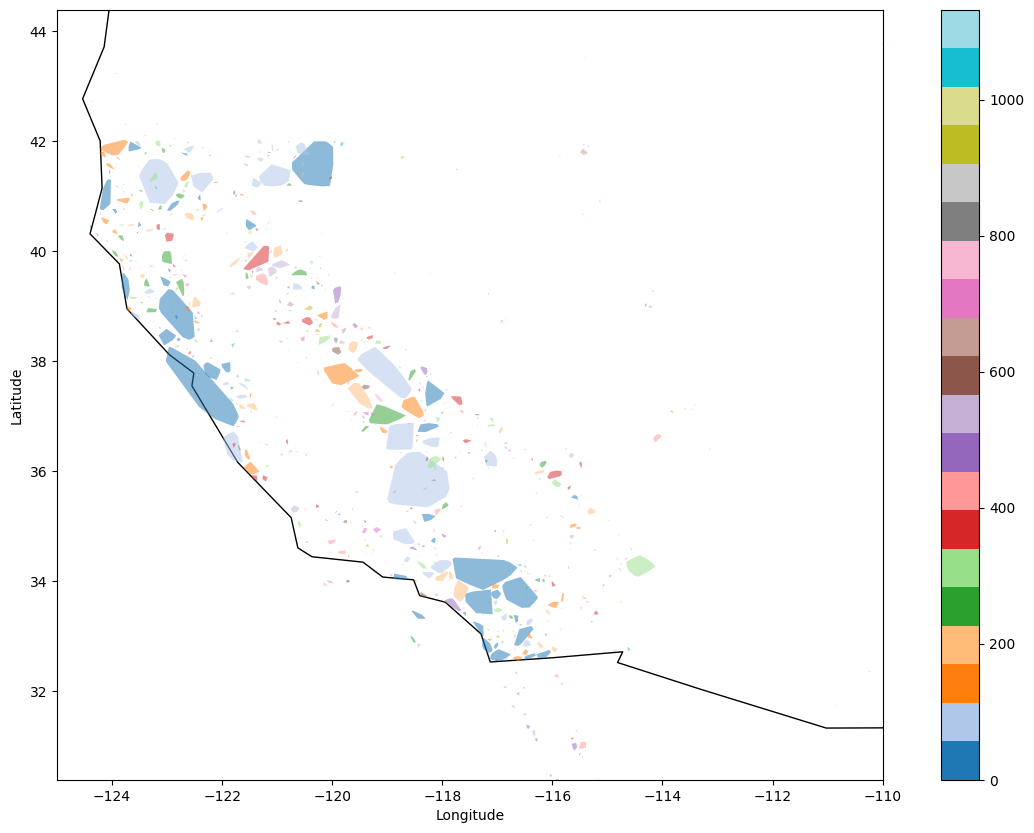

In [5]:
from scipy.spatial import ConvexHull
import matplotlib.pyplot as plt
from shapely.geometry import Polygon, MultiPolygon
import geopandas as gpd
import alphashape

def create_alpha_shapes(df, alpha=0.1):
    polygons = []
    for cluster in df['cluster'].unique():
        if cluster == -1:
            continue
        points = df[df['cluster'] == cluster][['longitude1', 'latitude1']].values
        if len(points) < 3:
            continue  # Skip clusters with fewer than 3 points
        try:
            alpha_shape = alphashape.alphashape(points, alpha)
            if alpha_shape.geom_type == 'Polygon':
                polygons.append({'cluster': cluster, 'geometry': alpha_shape})
            elif alpha_shape.geom_type == 'MultiPolygon':
                for poly in alpha_shape:
                    polygons.append({'cluster': cluster, 'geometry': poly})
        except Exception as e:
            #print(f"Skipping cluster {cluster} due to error: {e}")
            continue
    return polygons

polygons = create_alpha_shapes(data_us)

# Create a GeoDataFrame from the polygons
gdf = gpd.GeoDataFrame(polygons)

world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
us = world[(world.name == "United States of America")]


us = us.cx[-125:-66.93457, 24.396308:49.384358]

# Plot the map with the clusters
fig, ax = plt.subplots(figsize=(15, 10))
us.plot(ax=ax, color='white', edgecolor='black')
gdf.plot(ax=ax, column='cluster', cmap='tab20', legend=True, alpha=0.5)

# Set axis limits to focus on the continental US
ax.set_xlim(-125, -110)
ax.set_ylim(30.396308, 44.384358)
ax.set_aspect('equal')

#plt.title('DBSCAN Clusters as Regions (Polygons) Overlaid on Western US Map')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.savefig('dbscan_hulls.png')
plt.show()

In [ ]:
from sklearn.metrics import silhouette_score

# Compute the silhouette score
labels = data_us['cluster']
sil_score = silhouette_score(features, labels)
print(f"Silhouette Score: {sil_score}")